In [1]:
import os
import glob as glob
import matplotlib.pyplot as plt
import cv2
import random
import numpy as np

SEED = 42
np.random.seed(SEED)

In [2]:
# Constant
EPOCHS = 5
TRAIN = True

## Check Dataset Balance

In [3]:
# Define the paths
dataset_path = 'dataset'
augmented_dataset_path = 'augmented_dataset'

images_train_path = os.path.join(dataset_path, "images/train")
images_val_path = os.path.join(dataset_path, "images/val")
labels_train_path = os.path.join(dataset_path, "labels/train")
labels_val_path = os.path.join(dataset_path, "labels/val")

augmented_images_train_path = os.path.join(augmented_dataset_path, "images/train")
augmented_images_val_path = os.path.join(augmented_dataset_path, "images/val")
augmented_labels_train_path = os.path.join(augmented_dataset_path, "labels/train")
augmented_labels_val_path = os.path.join(augmented_dataset_path, "labels/val")

# Function to count files in a directory
def count_files(directory, extension):
    return len([f for f in os.listdir(directory) if f.endswith(extension)])

# Check dataset balance
train_images_count = count_files(images_train_path, ".jpg")
train_labels_count = count_files(labels_train_path, ".txt")
val_images_count = count_files(images_val_path, ".jpg")
val_labels_count = count_files(labels_val_path, ".txt")

augmented_train_images_count = count_files(augmented_images_train_path, ".jpg")
augmented_train_labels_count = count_files(augmented_labels_train_path, ".txt")
augmented_val_images_count = count_files(augmented_images_val_path, ".jpg")
augmented_val_labels_count = count_files(augmented_labels_val_path, ".txt")

print(f"Training Images: {train_images_count}")
print(f"Training Labels: {train_labels_count}")
print(f"Validation Images: {val_images_count}")
print(f"Validation Labels: {val_labels_count}")
print(f"\nAugmented Training Images: {augmented_train_images_count}")
print(f"Augmented Training Labels: {augmented_train_labels_count}")
print(f"Augmented Validation Images: {augmented_val_images_count}")
print(f"Augmented Validation Labels: {augmented_val_labels_count}")

Training Images: 7000
Training Labels: 7000
Validation Images: 1572
Validation Labels: 1572

Augmented Training Images: 7000
Augmented Training Labels: 7000
Augmented Validation Images: 1572
Augmented Validation Labels: 1572


## Visualize a Few Ground Truth Images

In [4]:
class_names = ['swimming', 'tread water', 'drowning']
colors = np.random.uniform(0, 150, size=(len(class_names), 3))

In [5]:
# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [6]:
def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # denormalize the coordinates
        xmin = int(x1*w)
        ymin = int(y1*h)
        xmax = int(x2*w)
        ymax = int(y2*h)
        width = xmax - xmin
        height = ymax - ymin
        
        class_name = class_names[int(labels[box_num])]
        
        cv2.rectangle(
            image, 
            (xmin, ymin), (xmax, ymax),
            color=colors[class_names.index(class_name)],
            thickness=2
        ) 

        font_scale = min(1,max(3,int(w/500)))
        font_thickness = min(2, max(10,int(w/50)))
        
        p1, p2 = (int(xmin), int(ymin)), (int(xmax), int(ymax))
        # Text width and height
        tw, th = cv2.getTextSize(
            class_name, 
            0, fontScale=font_scale, thickness=font_thickness
        )[0]
        p2 = p1[0] + tw, p1[1] + -th - 10
        cv2.rectangle(
            image, 
            p1, p2,
            color=colors[class_names.index(class_name)],
            thickness=-1,
        )
        cv2.putText(
            image, 
            class_name,
            (xmin+1, ymin-10),
            cv2.FONT_HERSHEY_SIMPLEX,
            font_scale,
            (255, 255, 255),
            font_thickness
        )
    return image

In [7]:
# Function to plot images with the bounding boxes.
def plot(image_paths, label_paths, num_samples):
    all_training_images = glob.glob(image_paths)
    all_training_labels = glob.glob(label_paths)
    all_training_images.sort()
    all_training_labels.sort()
    
    num_images = len(all_training_images)
    
    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        j = random.randint(0,num_images-1)
        image = cv2.imread(all_training_images[j])
        with open(all_training_labels[j], 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label = label_line[0]
                bbox_string = label_line[2:]
                x_c, y_c, w, h = bbox_string.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.subplots_adjust(wspace=0)
    plt.tight_layout()
    plt.show()

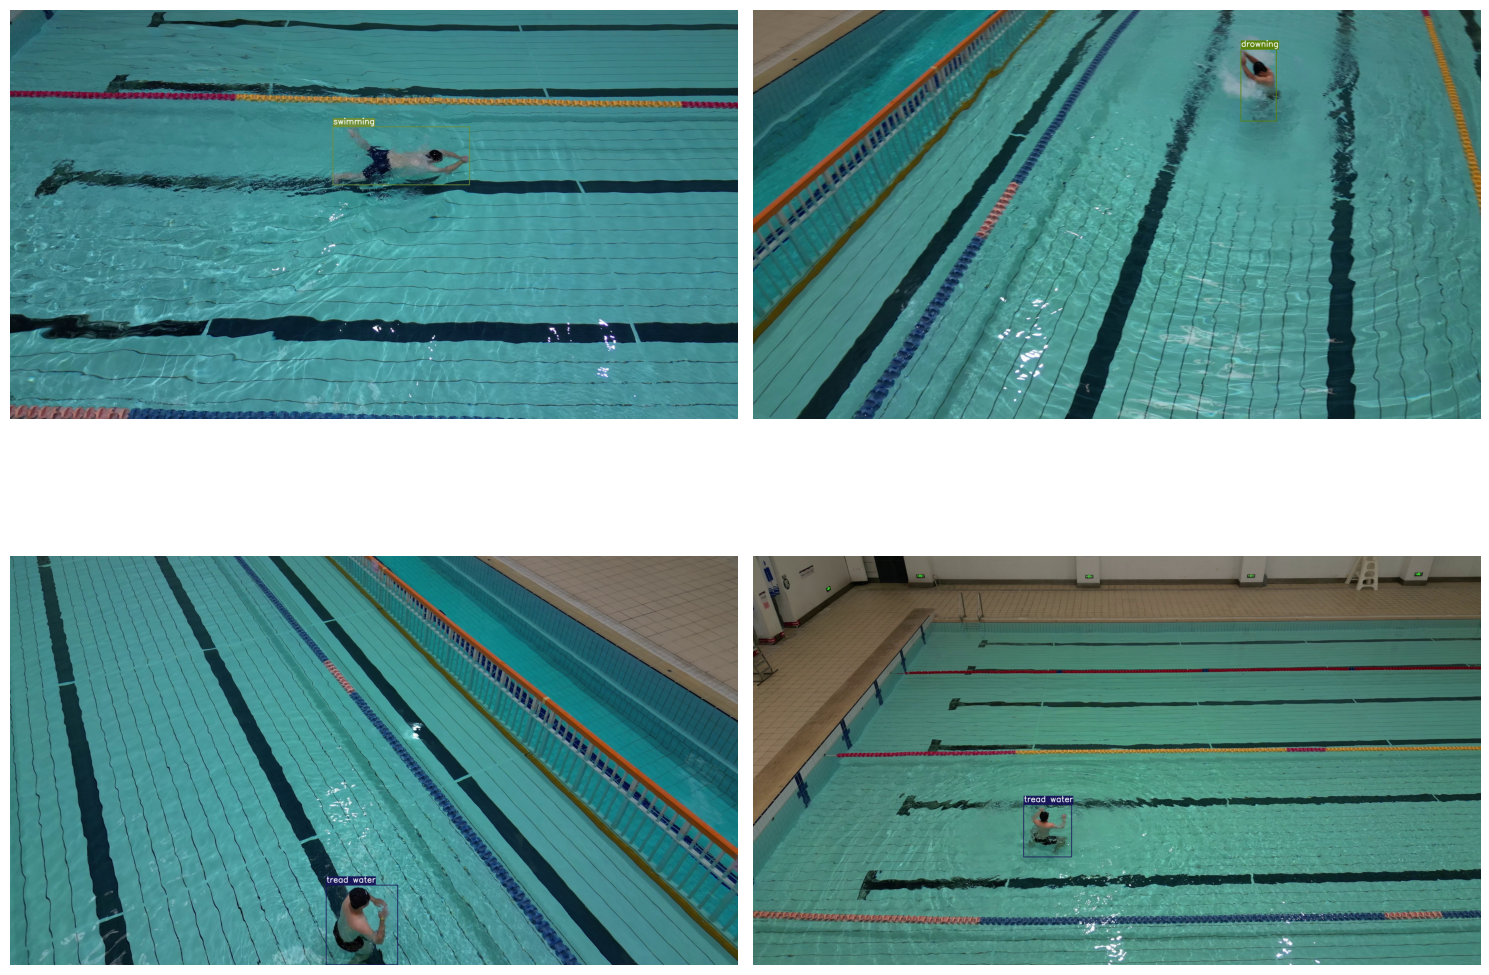

In [8]:
# Visualize a few training images.
plot(
    image_paths='dataset/images/train/*', 
    label_paths='dataset/labels/train/*',
    num_samples=4
)

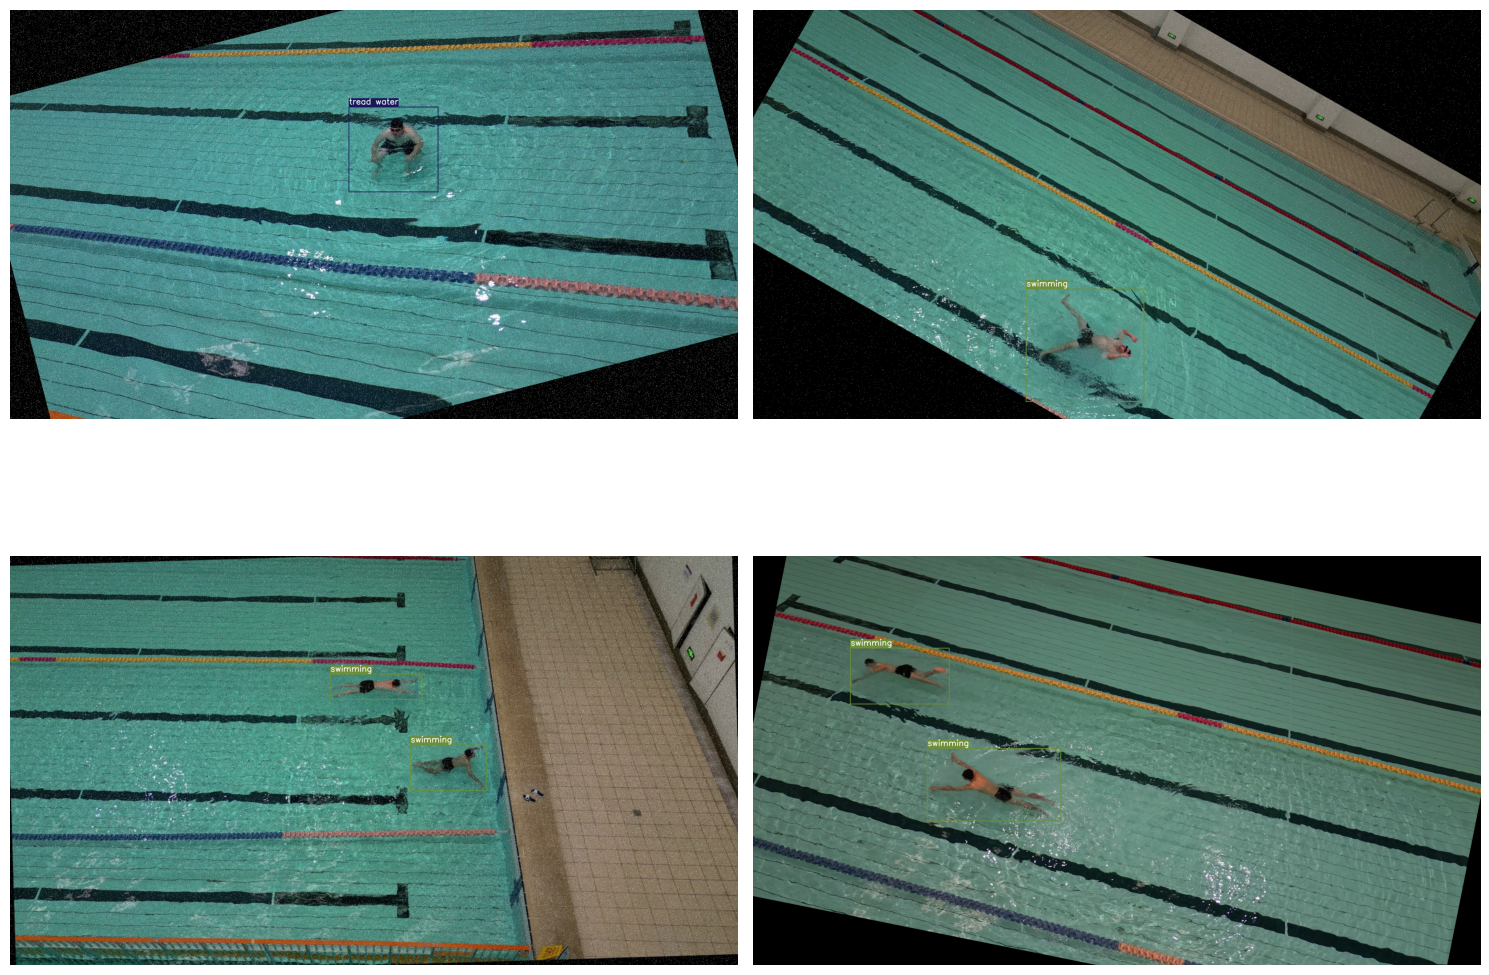

In [9]:
# Visualize a few augmented training images.
plot(
    image_paths='augmented_dataset/images/train/*', 
    label_paths='augmented_dataset/labels/train/*',
    num_samples=4
)

## Helper Functions for Logging Result

In [3]:
def set_res_dir():
    # Directory to store results
    res_dir_count = len(glob.glob('runs/train/*'))
    print(f"Current number of result directories: {res_dir_count}")
    if TRAIN:
        RES_DIR = f"results_{res_dir_count+1}"
        print(RES_DIR)
    else:
        RES_DIR = f"results_{res_dir_count}"
    return RES_DIR

**Function to Monitor TensorBoard logs**.

In [4]:
def monitor_tensorboard():
    %reload_ext tensorboard
    %tensorboard --logdir runs/train --port 6006

## Clone YOLOV5 Repository

In [32]:
if not os.path.exists('yolov5'):
    !git clone https://github.com/ultralytics/yolov5.git

Cloning into 'yolov5'...


In [5]:
%cd yolov5/
!pwd

C:\Users\hgtan\drowning_detection\yolov5


'pwd' is not recognized as an internal or external command,
operable program or batch file.


In [35]:
!pip install -r requirements.txt

## Training Using YOLOv5

### yolov5s model

In [9]:
monitor_tensorboard()

Reusing TensorBoard on port 6006 (pid 13412), started 9:39:25 ago. (Use '!kill 13412' to kill it.)

In [27]:
RES_DIR = set_res_dir()
if TRAIN:
    !python train.py --data data/data.yaml --weights yolov5s.pt \
    --img 640 --epochs {EPOCHS} --batch-size 32 --name {RES_DIR}

Current number of result directories: 0
results_1
^C


In [8]:
# To resume the train session
TRAIN = False
RES_DIR = set_res_dir()

!python train.py --data data/data.yaml --weights yolov5s.pt \
--img 640 --epochs {EPOCHS} --batch-size 32 --name {RES_DIR} \
--resume runs/train/{RES_DIR}/weights/last.pt

Current number of result directories: 1


Traceback (most recent call last):
  File "C:\Users\hgtan\drowning_detection\yolov5\train.py", line 47, in <module>
    import val as validate  # for end-of-epoch mAP
    ^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\hgtan\drowning_detection\yolov5\val.py", line 39, in <module>
    from models.common import DetectMultiBackend
  File "C:\Users\hgtan\drowning_detection\yolov5\models\common.py", line 39, in <module>
    from utils.dataloaders import exif_transpose, letterbox
  File "C:\Users\hgtan\drowning_detection\yolov5\utils\dataloaders.py", line 29, in <module>
    from utils.augmentations import (
  File "C:\Users\hgtan\drowning_detection\yolov5\utils\augmentations.py", line 13, in <module>
    from utils.general import LOGGER, check_version, colorstr, resample_segments, segment2box, xywhn2xyxy
  File "C:\Users\hgtan\drowning_detection\yolov5\utils\general.py", line 32, in <module>
    import pkg_resources as pkg
  File "C:\Users\hgtan\anaconda3\Lib\site-packages\pkg_resources\__init__.py

In [47]:
import tensorboard
import os
import time

def main():
    tb = tensorboard.program.TensorBoard()
    tb.configure(bind_all=True, logdir="/tmp/logs")
    url = tb.launch()
    print("TensorBoard %s started at %s" % (tensorboard.__version__, url))
    pid = os.getpid()
    print("PID = %d; use 'kill %d' to quit" % (pid, pid))
    while True:
        try:
            time.sleep(60)
        except KeyboardInterrupt:
            break
    print()
    print("Shutting down")


if __name__ == "__main__":
    main()

TensorBoard 2.17.1 started at http://LAPTOP-SM3AE451:6007/
PID = 20116; use 'kill 20116' to quit

Shutting down
